# **Ground truth generation**

This notebook aims to generate responses by three LLM's to generate risks and identify conflicts with mission statement. It starts by generating responses with the same subset used for the survey with human annotation then it compares using precision, recall, bert score, bart and rouge.
Then it generates answers in a larger sample of companies. The final outputs are a dataset called **llm_survey** with the companies used in the survey and **3_llm_answers** that contains the subset of 200 companies. Both datasets have the following columns:


1.   Task1_dom_LLaMA', 'Task1_dom_Qwen', 'Task1_dom_Nemotron' (with only the risk domain names)
       
2.   'Task1__text_LLaMA', 'Task1_text_Qwen', 'Task1_text_Nemotron' (with the specific risks or open responses)
3. 'Task1_majority_risk_categories', 'Task1_majority_risk_texts'  (Task 1 domain names and stacked texts from the domains selected by at least 2 LLM's)
4. 'Task2_dom_LLaMA', 'Task2_dom_Qwen', 'Task2_dom_Nemotron' (Task 2 risks that conflict with mission)
5. 'Task2_text_LLaMA', 'Task2_text_Qwen', 'Task2_text_Nemotron'
6. 'Task2_majority_risk_categories', 'Task2_majority_risk_texts' (Task 2 domain names and stacked texts from the domains selected by at least 2 LLM's)

In [ ]:
! pip install -U langchain_community tiktoken langchain langchain-ollama krippendorff openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00


**Companies database**

In [ ]:
import pandas as pd
companies = pd.read_csv('1_companies_df.csv') #the output from 1_ description_and_usecases notebook with the 441 companies with validated missions
companies

,ID,Company,Revenues ($M),Revenue Percent Change,Profits ($M),Profits Percent Change,Assets ($M),Employees,ID BvD,ISO,...,Validated,Missions_validated,Sector BvD,Description,l,Usecases_1,Usecases_2,Usecases_3,Usecases_USC,Description_summary
0,1,Walmart,"$648,125",0.06,"$15,511",0.328,"$252,399",2100000,1,US,...,1,We aim to build a better world — helping peopl...,Retail,"Walmart Inc., incorporated on October 31, 1969...",3124,"AI for demand forecasting, AI-enhanced supply ...",AI-driven demand forecasting for inventory man...,"AI-driven dynamic pricing, Predictive inventor...",AI-driven demand forecasting for inventory man...,Walmart is a technology-powered omnichannel re...
1,2,Amazon,"$574,785",0.118,"$30,425",-,"$527,854",1525000,2,US,...,1,"As part of Amazon, we strive to be Earth’s mos...",Retail,"Amazon.com, Inc. provides a range of products ...",3933,"Recommendation engine improvement, Logistics o...","AI-powered product recommendation engine, Pred...",AI-driven personalized shopping recommendation...,"AI-powered product recommendation engine, Pred...",Amazon is an e-commerce giant offering product...
2,3,State Grid,"$545,947.5",0.03,"$9,204.3",0.124,"$781,126.2",1361423,3953,CN,...,1,"Power Your Beautiful Life, Empower Our Beautif...",NaN,Engaged in the operation and management of ele...,122,"AI for energy grid optimization, AI-powered ou...","AI predicts power grid energy demand, Detects ...","AI for predictive maintenance of grid assets, ...","AI predicts power grid energy demand, Detects ...",State Grid operates and manages electric power...
3,4,Saudi Aramco,"$494,890.1",-0.18,"$120,699.3",-0.241,"$660,819.2",73311,3,SA,...,1,"Aramco strives to provide reliable, affordable...",Mining & Extraction,"The company is engaged in the exploration, pro...",3687,"AI enhances oil reservoir management, AI optim...","AI predicts oil reservoir depletion rates, Det...","AI for predictive maintenance of oil rigs, Opt...","AI for predictive maintenance of oil rigs, Opt...",Saudi Aramco is a leading integrated energy an...
4,5,Sinopec Group,"$429,699.7",-0.088,"$9,393.4",-0.027,"$382,688",513434,4,CN,...,1,Powering a better life,Mining & Extraction,"China Petroleum & Chemical Corporation (the ""C...",2499,"AI for catalyst optimization, AI-powered predi...","Predictive Maintenance for Refinery Equipment,...","AI optimizes refinery operations, Predicts equ...","AI optimizes refinery operations, Predicts equ...",Sinopec Group is a Chinese energy and chemical...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,495,Subaru,"$32,540.1",0.167,"$2,664.4",0.799,"$31,835.4",37693,848,JP,...,1,We aim to be a compelling company with a stron...,Transport Manufacturing,The Companyis a Japan-based company engaged in...,716,"Predictive maintenance for vehicles, AI-powere...","AI predicts vehicle maintenance needs, Enhance...","AI for predictive maintenance of vehicles, AI-...","AI for predictive maintenance of vehicles, AI-...",Subaru manufactures and sells Subaru automobil...
437,496,Air France-KLM Group,"$32,452.3",0.169,"$1,009.7",0.319,"$38,093.7",76271,772,FR,...,1,to be at the forefront of a more responsible E...,"Transport, Freight & Storage",The Company is one of the world's leading airl...,521,"AI for route optimization, AI-powered customer...","Predictive Aircraft Maintenance Scheduling, AI...","AI for flight schedule optimization, AI-powere...","Predictive Aircraft Maintenance Scheduling, AI...",Air France-KLM Group is a leading global airli...
438,497,Enbridge,"$32,349.5",-0.21,"$4,588.3",0.988,"$136,769.6",12450,792,CA,...,1,to be the first choice for energydelivery in N...,Utilities,Enbrige Inc (formerly IPL Energy Inc) is engag...,3147,"AI-enhanced pipeline inspections, AI-powered l...",AI monitors pipeline integrity for leak detect...,"AI for predictive maintenance of pipelines, AI...",AI monitors pipeline integrity for leak detect...,Enbridge operates North America's largest crud...
439,498,

**Survey database**

In [ ]:
#the output from 2_survey with the companies datset used in the survey and the answers by the annotators
subset_survey = pd.read_csv('2_companies_survey.csv')

In [ ]:
subset_survey

,ID,Company,Revenues ($M),Revenue Percent Change,Profits ($M),Profits Percent Change,Assets ($M),Employees,ID BvD,ISO,...,Usecases_1,Usecases_2,Usecases_3,Usecases_USC,Description_summary,Company ID,Task1_majority_risk_survey,Task2_majority_risk_survey,Task1_majority_texts_survey,Task2_majority_texts_survey
0,201,Korea Electric Power,"$66,977.2",0.226,"$-3,692.4",-,"$185,048.1",48696,272,KR,...,"AI-assisted power grid optimization, AI for pr...","Predictive Grid Failure Detection, AI-driven E...","AI for predictive maintenance of generators, O...","AI for predictive maintenance of generators, O...",Korea Electric Power generates and sells elect...,201,"['Malicious actors', 'Socioeconomic & Environm...","['Privacy & Security', 'Malicious actors', 'Hu...",Malicious actors could hack the system to conv...,This conflicts with their commitment to a brig...
1,104,Société Générale,"$99,163.4",0.564,"$2,695.1",0.27,"$1,716,418.2",124089,978,FR,...,"Fraud detection in transactions, AI-based fina...","AI-powered credit risk assessment, Chatbots fo...","AI for fraud detection, Personalized financial...","AI for fraud detection, Personalized financial...",Société Générale provides diverse financial se...,104,"['Discrimination & Toxicity', 'Misinformation'...","['Discrimination & Toxicity', 'Misinformation'...",AIs are trained on media that could be biased ...,"It conflicts with building ""together"" since it..."
2,183,Airbus,"$70,751",0.145,"$4,096.1",-0.083,"$131,291.1",147893,250,NL,...,"AI-powered predictive maintenance, Autonomous ...","AI predicts aircraft maintenance schedules, En...","AI for predictive maintenance of aircraft, AI ...","AI predicts aircraft maintenance schedules, En...","Airbus designs, manufactures, and sells commer...",183,"['Malicious actors', 'Human- Computer Interact...","['Privacy & Security', 'Malicious actors', 'Hu...",The systems could be hacked to provide dangero...,"It conflicts with keeping a ""safe"" world., It ..."
3,205,Deutsche Bank,"$65,978.1",0.560,"$6,845.3",0.201,"$1,454,899.5",90130,828,DE,...,"AI-driven portfolio management, Fraud detectio...","AI-enhanced credit risk assessment, Chatbots f...","AI for fraud detection, AI-driven trading algo...","AI-enhanced credit risk assessment, Chatbots f...",Deutsche Bank is a global financial services p...,205,"['Discrimination & Toxicity', 'Misinformation'...","['Discrimination & Toxicity', 'Misinformation'...",Biased credit algorithms or unequal chatbot pe...,Unfair treatment through biased AI blocks acce...
4,1,Walmart,"$648,125",0.060,"$15,511",0.328,"$252,399",2100000,1,US,...,"AI for demand forecasting, AI-enhanced supply ...",AI-driven demand forecasting for inventory man...,"AI-driven dynamic pricing, Predictive inventor...",AI-driven demand forecasting for inventory man...,Walmart is a technology-powered omnichannel re...,1,"['Misinformation', 'Human- Computer Interactio...","['Misinformation', 'AI system safety, failures...",Chatbots can provide vague and unhelpful tips ...,It would only cause frustrations for customers...
5,425,Olam Group,"$35,952.8",-0.098,$207.6,-0.545,"$25,287.1",65980,663,SG,...,"Optimize crop yield predictions, AI-powered su...",AI forecasts crop yields for supplier optimiza...,"AI for crop yield prediction, AI-driven invent...","AI for crop yield prediction, AI-driven invent...",Olam Group is a leading food and agribusiness ...,425,"['Misinformation', 'Privacy & Security', 'Mali...","['Discrimination & Toxicity', 'Misinformation'...","Inaccurate AI outputs in crop forecasting, inv...",Misleading AI outputs can lead to poor decisio...
6,78,China Southern Power Grid,"$118,813.5",0.045,"$2,342.2",0.546,"$173,039.2",268471,2780,CN,...,"AI predictive maintenance for transformers, AI...","Predictive Maintenance for Grid Equipment, AI-...","AI for predictive maintenance of power lines, ...","Predictive Maintenance for Grid Equipment, AI-...",Operates and manages southern China's regional...,78,"['Privacy & Security', 'Malicious 

In [ ]:
# Get the IDs of companies in subset_missions
subset_survey_ids = subset_survey['ID'].tolist()

# Filter the original missions dataset to exclude these IDs
remaining_missions = companies[~companies['ID'].isin(subset_survey_ids)]

# Sample 200 companies from the remaining missions
subset_llm = remaining_missions.sample(n=200, random_state=42) #the random set of companies for the ground truth
subset_llm

,ID,Company,Revenues ($M),Revenue Percent Change,Profits ($M),Profits Percent Change,Assets ($M),Employees,ID BvD,ISO,...,Validated,Missions_validated,Sector BvD,Description,l,Usecases_1,Usecases_2,Usecases_3,Usecases_USC,Description_summary
162,185,Zhejiang Geely Holding Group,"$70,356.8",0.165,$812.6,-0.14,"$94,120.3",143994,1665,CN,...,1,"Align strategies, drive change and create value",NaN,General projects: engage in investment activit...,1193,"AI-assisted vehicle design optimization, AI-po...","AI predicts vehicle maintenance needs, Enhance...","AI for predictive maintenance of vehicles, AI-...","AI for predictive maintenance of vehicles, AI-...","Zhejiang Geely Holding Group designs, manufact..."
421,476,Power Corp. of Canada,"$33,264.8",-0.111,"$1,665.3",0.103,"$568,475.4",40300,2554,CA,...,1,We build on our strong core values and sound i...,"Banking, Insurance & Financial Services",The Company is a diversified management and ho...,568,"AI-powered fraud detection, AI optimizes under...","AI-driven risk assessment for policyholders, C...","AI for risk assessment in insurance, AI-driven...","AI for risk assessment in insurance, AI-driven...",Diversified management and holding company wit...
435,493,Vibra Energia,"$32,634.1",-0.072,$954.5,2.205,"$8,961.3",3526,724,BR,...,1,To move Brazil with its best energy.,Retail,"The Company was founded on November 12, 1971 i...",1348,"Forecast demand for petrol, Optimize logistics...",AI forecasts fuel demand for inventory managem...,"AI for predictive maintenance of pipelines, Op...",AI forecasts fuel demand for inventory managem...,"Vibra Energia distributes, transports, and mar..."
100,113,Brookfield,"$95,924",0.034,"$1,130",-0.45,"$490,095",240000,127,CA,...,1,We invest on behalf of institutions and indivi...,Property Services,The Company is a North American based company ...,1781,"AI-enhanced property valuation, AI-driven port...","AI-driven property valuation analysis, Predict...",AI for predictive maintenance of infrastructur...,"AI-driven property valuation analysis, Predict...",Brookfield owns and manages assets generating ...
74,85,Xiamen C&D,"$110,665.6",-0.122,"$1,057.6",1.328,"$125,003.2",62740,115,CN,...,1,To exploit new value for more people to live a...,NaN,Our Company is mainly engaged in providing com...,576,"AI-powered trade route optimization, Smart inv...",AI predicts freight routing for reduced transi...,AI for predictive maintenance of fleet vehicle...,AI predicts freight routing for reduced transi...,Xiamen C&D provides comprehensive logistics an...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,397,Xiaomi,"$38,276.8",-0.081,"$2,468.5",5.712,"$45,682.8",33627,636,CN,...,1,Build amazing products with honest prices to l...,Business Services,Xiaomi Corporation is a company with limited l...,1030,"AI-optimized camera performance, AI for energy...","AI-powered smartphone camera enhancements, Pre...","AI-driven product recommendations, Predictive ...","AI-powered smartphone camera enhancements, Pre...","Xiaomi develops and sells smartphones, IoT dev..."
72,83,China Post Group,"$112,778.5",0.023,"$5,884.5",0.202,"$2,310,571.9",728776,45456,CN,...,1,serving the development of the real economy an...,NaN,China Post Group operates China's postal and e...,219,"AI for parcel sorting optimization, AI-powered...","AI routes parcels for efficient delivery, Pred...","AI for route optimization, Predictive maintena...","AI for route optimization, Predictive maintena...",China Post Group operates China's postal and e...
25,28,Stellantis,"$204,908.3",0.085,"$20,103.4",0.138,"$223,247.2",258275,31,NL,...,1,"Powered by our diversity, we lead the way the ...",Transport Manufacturing,"The Company was founded on July 11, 1899. The ...",501,"AI for autonomous network optimization, AI-pow...","AI-driven predictive vehicle maintenance, Pers...",AI for predictive maintenance on production li...,"AI-driven predictive vehicle maintenance, Pers...",

**MIT domain taxonomy**

In [ ]:
mit_risks = pd.read_excel('Missions.xlsx', sheet_name="MIT_domain")
mit_domains = "\n".join(mit_risks["Domain"])
mit_descriptions = "\n".join(
    f"{row['Domain']}: {row['Description']}" for _, row in mit_risks.iterrows()
)

**Libraries**

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama
from langchain_core.prompts import ChatPromptTemplate

This first prompt instructs the LLM to select relevant risks domains based on the company profile.

In [ ]:
task_1_prompt = [
    {
        "role": "system",
        "content": """You are an expert in AI risk assessment in {sector} sector.

Your task is to identify **all AI risk domains that are relevant** to a company based on its **description, sector, and AI use cases**. The risk taxonomy includes both domain names and their definitions.

Instructions:
1. Carefully read the company’s **description**, **sector**, and **AI use cases**.
2. Review the full list of domain names and definitions provided.
3. Select **every domain** that is clearly associated with risks arising from the company’s operation and potential AI use cases. Use the description, AI use cases and industry as context to interpret how these risks might manifest.
4. For each selected domain:
   - Write **2 to 3 specific and plausible AI risks** associated to the selected domain and grounded in the company’s operation and potential AI use cases.
   - Each risk must be **35 words or fewer**.
   - Format all risks under a given domain as a **semicolon-separated string**.
5. Return a **valid JSON object only**:
   - Keys = domain names (exactly as listed).
   - Values = a single string with semicolon-separated risks.

Important:
- Be comprehensive. Do **not** arbitrarily limit the number of domains.
- Only include domains clearly associated with the company's operation and potential AI use cases.
- Do **not** include markdown, preambles, explanations, or unrelated categories.

Your output must exactly match this format:
```json
{{
  "Domain A": "Specific risk 1; Specific risk 2",
  "Domain B": "Specific risk 3; Specific risk 4; Specific risk 5"
}}
"""
},
    {"role": "user",
        "content": """Company: {company}
Sector: {sector}
Description: {description}
AI Use Cases: {usecases}

Available AI Risk Domains:
{mit_domains}

Domain Definitions:
{mit_descriptions}
"""
    },

]

This second prompt assess the conflict with the mission based on the output, selected risks domains, from the first prompt.

In [ ]:
task_2_prompt = [
    {"role": "system",
        "content": """You are an expert in AI risk assessment in {sector} sector.

Your task is to assess whether AI risks conflict with a company’s mission.

You will be given:
- The company’s name, description, and sector
- The company’s mission statement
- A dictionary of AI risks, grouped by domain. Each key is a risk domain, and the value is a list of specific risks.

Instructions:
1. Read the mission carefully. Identify what the company values and aims.
2. For each domain and its associated risks:
   - Decide whether the domain and risks **clearly challenge, conflict or contradict any part or if all** of the company’s mission.
   - If so, set `"ConflictsMission": "yes"`.
     - In the `"Explanation"`, **name the specific part of the mission that is conflicted** and provide a **comprehensive explanation of how and why the domain risk and specific risks conflicts with the mission**.
   - If not, set `"ConflictsMission": "no"`.
     - In the `"Explanation"`, state why the risks do not interfere with the mission.

3. Each explanation must be **maximum 35 words**.
4. Return your output as a valid JSON object, using this exact format:
```json
{{
  "Domain A": {{
    "ConflictsMission": "yes",
    "Explanation": ""
  }},
  "Domain B": {{
    "ConflictsMission": "no",
    "Explanation": ""
  }}"""
},
    {"role": "user",
        "content": """Company: {company}
Sector: {sector}
Description: {description}
Mission: {mission}

AI Risks by domain:
{task_1_output}
"""
    }
]

In [ ]:
from langchain_core.output_parsers import JsonOutputParser
# Prompt and parser
prompt_task_1 = ChatPromptTemplate.from_messages(task_1_prompt)
risk_parser = JsonOutputParser()

# Define three LLMs (assuming you have them via Ollama or equivalent)
from langchain_ollama import ChatOllama

llm_llama = ChatOllama(model="llama3.3:70b", format="json")
llm_qwen = ChatOllama(model="qwen2.5:72b", format="json")
llm_nemotron = ChatOllama(model="nemotron:70b", format="json")

# Define chains
chain_llama = prompt_task_1 | llm_llama | risk_parser
chain_qwen = prompt_task_1 | llm_qwen | risk_parser
chain_nemotron = prompt_task_1 | llm_nemotron | risk_parser

In [ ]:
# Prompt and parser
prompt_task_2 = ChatPromptTemplate.from_messages(task_2_prompt)
conflict_parser = JsonOutputParser()

# Define chains
chain2_llama = prompt_task_2 | llm_llama | conflict_parser
chain2_qwen = prompt_task_2 | llm_qwen | conflict_parser
chain2_nemotron = prompt_task_2 | llm_nemotron | conflict_parser

In [ ]:
import json
from tqdm import tqdm

outputs_llama  = []
outputs_llama2 = []

# Iterate over only the first row, just to test and review the outputs
for _, row in tqdm(subset_survey.head(1).iterrows(), total=1):
    company     = row["Company"].strip()
    description = row["Description_summary"].strip()
    sector    = row["Sector"].strip()
    usecases    = row["Usecases_USC"].strip()
    mission     = row["Missions_validated"].strip()

    # 1) Invoke chain_llama
    input1 = {
        "company":         company,
        "description":     description,
        "sector":        sector,
        "usecases":        usecases,
        "mit_domains":     mit_domains,
        "mit_descriptions": mit_descriptions
    }

    try:
        result1 = chain_llama.invoke(input1)
    except Exception as e:
        result1 = {"error": str(e)}
    outputs_llama.append(result1)

    # 2) Invoke chain2_llama using result1
    input2 = {
        "company":       company,
        "description":   description,
        "sector":      sector,
        "mission":       mission,
        "task_1_output": json.dumps(result1)
    }

    try:
        result2 = chain2_llama.invoke(input2)
    except Exception as e:
        result2 = {"error": str(e)}
    outputs_llama2.append(result2)

100%|██████████| 1/1 [01:37<00:00, 97.77s/it]


In [ ]:
outputs_llama2

[{'Privacy & Security': {'ConflictsMission': 'yes',
   'Explanation': 'Data leaks and hacking undermine trust.'},
  'Malicious actors': {'ConflictsMission': 'yes',
   'Explanation': 'Sabotage and remote control harm value creation.'},
  'Human- Computer Interaction': {'ConflictsMission': 'yes',
   'Explanation': 'Distracted driving and lack of trust reduce value.'},
  'Socioeconomic & Environmental': {'ConflictsMission': 'yes',
   'Explanation': 'Job displacement and unfair benefits distribution hinder value creation.'},
  'AI system safety, failures, & limitations': {'ConflictsMission': 'yes',
   'Explanation': 'Vehicle control failures and biased driving harm change and value.'}}]

**Llama 3.3 70B**

After the testing, I iterate over the full rows on the survey dataset with the 24 companies. First, the first prompt using Llama 3.3

In [ ]:
from tqdm import tqdm

outputs_llama_survey = []

for _, row in tqdm(subset_survey.iterrows(), total=len(subset_survey)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    usecases = row["Usecases_USC"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "usecases": usecases.strip(),
        "mit_domains": mit_domains,
        "mit_descriptions": mit_descriptions
    }

    try:
        result_llama = chain_llama.invoke(input_dict)
    except Exception as e:
        result_llama = {"error": str(e)}
    outputs_llama_survey.append(result_llama)

100%|██████████| 24/24 [15:02<00:00, 37.61s/it]


In [ ]:
outputs_llama_survey

[{'Privacy & Security': 'Exposes grid control systems to cyberattacks through vulnerable AI interfaces; Leaks sensitive energy trading data to unauthorized parties; Compromises predictive maintenance schedules, disrupting power generation.',
  'Malicious actors': 'Manipulates AI-optimized grid load balancing for targeted blackouts; Exploits AI-enhanced energy trading for market manipulation; Uses AI-generated disinformation to influence energy policy.',
  'AI system safety, failures, & limitations': 'Fails to predict critical generator faults due to data quality issues; Miscalculates optimal grid load balancing, causing power outages; Lacks transparency in AI-driven energy trading decisions, hindering auditability.',
  'Socioeconomic & Environmental': 'Increases reliance on non-renewable energy sources due to biased AI optimization; Disrupts local ecosystems through inefficient resource allocation; Exacerbates energy poverty by prioritizing high-profit trades over equitable access.',
 

In [ ]:
subset_survey["Task1_LLaMA"] = outputs_llama_survey

The second prompt using Llama 3.3

In [ ]:
import json
outputs_llama2_survey = []

for _, row in tqdm(subset_survey.iterrows(), total=len(subset_survey)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    mission = row["Missions_validated"]
    task_1 = row["Task1_LLaMA"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "mission": mission.strip(),
        "task_1_output": json.dumps(task_1), # Convert dictionary to JSON string
    }

    try:
        result_llama = chain2_llama.invoke(input_dict)
    except Exception as e:
        result_llama = {"error": str(e)}
    outputs_llama2_survey.append(result_llama)

100%|██████████| 24/24 [11:24<00:00, 28.54s/it]


In [ ]:
outputs_llama2_survey

[{'Privacy & Security': {'ConflictsMission': 'yes',
   'Explanation': 'Cyberattacks disrupt power, hindering a brighter future.'},
  'Malicious actors': {'ConflictsMission': 'yes',
   'Explanation': 'Manipulation causes blackouts, undermining commitment.'},
  'AI system safety, failures, & limitations': {'ConflictsMission': 'yes',
   'Explanation': 'Power outages hinder a brighter future.'},
  'Socioeconomic & Environmental': {'ConflictsMission': 'yes',
   'Explanation': 'Exacerbates energy poverty, contradicting mission.'},
  'Human- Computer Interaction': {'ConflictsMission': 'yes',
   'Explanation': 'Error risks hinder progress toward brighter future.'}},
 {'Discrimination & Toxicity': {'ConflictsMission': 'yes',
   'Explanation': 'Biased loan underwriting contradicts responsible solutions.'},
  'Privacy & Security': {'ConflictsMission': 'yes',
   'Explanation': 'Exposing customer data undermines trust and security.'},
  'Malicious actors': {'ConflictsMission': 'yes',
   'Explanatio

In [ ]:
subset_survey["Task2_LLaMA"] = outputs_llama2_survey

**Nemotron 70B**

Again, invoking the two chains for the survey companies but this time using Nemotron.

In [ ]:
#first prompt
outputs_nemotron_survey = []

for _, row in tqdm(subset_survey.iterrows(), total=len(subset_survey)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    usecases = row["Usecases_USC"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "usecases": usecases.strip(),
        "mit_domains": mit_domains,
        "mit_descriptions": mit_descriptions
    }

    try:
        result_nemotron = chain_nemotron.invoke(input_dict)
    except Exception as e:
        result_nemotron = {"error": str(e)}
    outputs_nemotron_survey.append(result_nemotron)

100%|██████████| 24/24 [19:45<00:00, 49.40s/it]


In [ ]:
subset_survey["Task1_Nemotron"] = outputs_nemotron_survey

In [ ]:
#Second prompt
outputs_nemotron2_survey = []

for _, row in tqdm(subset_survey.iterrows(), total=len(subset_survey)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    mission = row["Missions_validated"]
    task_1 = row["Task1_Nemotron"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "mission": mission.strip(),
        "task_1_output": json.dumps(task_1), # Convert dictionary to JSON string
    }

    try:
        result_nemotron = chain2_nemotron.invoke(input_dict)
    except Exception as e:
        result_nemotron = {"error": str(e)}
    outputs_nemotron2_survey.append(result_nemotron)

100%|██████████| 24/24 [16:30<00:00, 41.29s/it]


In [ ]:
subset_survey["Task2_Nemotron"] = outputs_nemotron2_survey

**Qwen 2.5 72B**

Again, invoking the two chains for the survey companies but this time using Qwen 2.5 72B.



In [ ]:
outputs_qwen_survey = []

for _, row in tqdm(subset_survey.iterrows(), total=len(subset_survey)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    usecases = row["Usecases_USC"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "usecases": usecases.strip(),
        "mit_domains": mit_domains,
        "mit_descriptions": mit_descriptions
    }
    try:
        result_qwen = chain_qwen.invoke(input_dict)
    except Exception as e:
        result_qwen = {"error": str(e)}
    outputs_qwen_survey.append(result_qwen)

100%|██████████| 24/24 [36:30<00:00, 91.29s/it]


In [ ]:
subset_survey["Task1_Qwen"] = outputs_qwen_survey

In [ ]:
outputs_qwen2_survey = []

for _, row in tqdm(subset_survey.iterrows(), total=len(subset_survey)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    mission = row["Missions_validated"]
    task_1 = row["Task1_Qwen"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "mission": mission.strip(),
        "task_1_output": json.dumps(task_1), # Convert dictionary to JSON string
    }

    try:
        result_qwen = chain2_qwen.invoke(input_dict)
    except Exception as e:
        result_qwen = {"error": str(e)}
    outputs_qwen2_survey.append(result_qwen)

100%|██████████| 24/24 [32:59<00:00, 82.47s/it]


In [ ]:
subset_survey["Task2_Qwen"] = outputs_qwen2_survey

**Proccesing the LLMs outputs**

The following lines of code, proccess the json outputs from the LLMs. First, it extracts the risks domains into a list for both tasks, then applies majority voting and aggregates the specific risks and conflict explanation.

In [ ]:
def extract_risks_from_outputs(task_outputs):
  """This function is to exxtract the risks from the Json output into a list of risks domains and the specific risks grounded in company profile"""
    domains = []
    risks = []

    for entry in task_outputs:
        # Skip if there's an error or entry is not a dict
        if not isinstance(entry, dict):
            domains.append([])
            risks.append([])
            continue

        domains_names = list(entry.keys())
        domains.append(domains_names)

        domain_risks = []
        for val in entry.values():
            if isinstance(val, str):
                items = [r.strip() for r in val.split(";") if r.strip()]
                domain_risks.extend(items)
        risks.append(domain_risks)

    return domains, risks

In [ ]:
#Applying the new function into the LLM outputs to extract the risks domains
categories_llama, risks_llama = extract_risks_from_outputs(subset_survey["Task1_LLaMA"])
categories_qwen, risks_qwen = extract_risks_from_outputs(subset_survey["Task1_Qwen"])
categories_nemotron, risks_nemotron = extract_risks_from_outputs(subset_survey["Task1_Nemotron"])

In [ ]:
#to rename the columns. Dom means the risks domains, and text means the specific risks based on company profile and domains selected
subset_survey["Task1_dom_LLaMA"] = categories_llama
subset_survey["Task1_text_LLaMA"] = risks_llama

subset_survey["Task1_dom_Qwen"] = categories_qwen
subset_survey["Task1_text_Qwen"] = risks_qwen

subset_survey["Task1_dom_Nemotron"] = categories_nemotron
subset_survey["Task1_text_Nemotron"] = risks_nemotron

**Majority voting**

In [ ]:
from collections import Counter

annotator_category_cols = ["Task1_dom_LLaMA", "Task1_dom_Qwen", "Task1_dom_Nemotron"]

for col in annotator_category_cols:

    # Attempt to convert string representations of lists (e.g., "[A, B]") to actual Python lists
    subset_survey[col] = subset_survey[col].apply(
        lambda x: eval(x) if isinstance(x, str) and x.strip().startswith('[') else x
    )
    # Ensure all values in these columns are lists by replacing NaN or other non-list types with an empty list
    subset_survey[col] = subset_survey[col].apply(lambda x: x if isinstance(x, list) else [])


# Calculate majority voting for risks domains
majority_voted_risks_per_company = []

for index, row in subset_survey.iterrows():
    # Collect all risk categories selected by the three annotators for the current company
    all_categories_for_current_company = []
    for col_name in annotator_category_cols:
        all_categories_for_current_company.extend(row[col_name])

    # Use Counter to count occurrences of each unique risk domain
    category_counts = Counter(all_categories_for_current_company)

    # Identify categories that were selected by at least 2 annotators
    current_company_majority_risks = [
        category for category, count in category_counts.items() if count >= 2
    ]

    majority_voted_risks_per_company.append(current_company_majority_risks)

# Add the new column to companies_survey
subset_survey["Task1_majority_risk_categories"] = majority_voted_risks_per_company

In [ ]:
#to collect the specific risks from the majority voted risks domains
# List of the columns containing the LLM output dictionaries
llm_task_cols = ["Task1_LLaMA", "Task1_Qwen", "Task1_Nemotron"]
final_majority_texts = []

# Iterate over each row of the survey database
for index, row in subset_survey.iterrows():
    majority_categories = row['Task1_majority_risk_categories']
    collected_row_texts = []

    # For each category that won the majority vote...
    for category in majority_categories:
        # check the output of each LLM
        for col in llm_task_cols:
            llm_output_dict = row[col]

            # Check if the output is a dictionary and if it contains the majority category
            if isinstance(llm_output_dict, dict) and category in llm_output_dict:

                # Retrieve the semicolon-separated string of texts
                texts_str = llm_output_dict[category]

                # Split the string into a list, stripping whitespace and removing empty items
                if isinstance(texts_str, str):
                    risk_items = [text.strip() for text in texts_str.split(';') if text.strip()]
                    collected_row_texts.extend(risk_items)

    final_majority_texts.append(collected_row_texts)

# Create the new column with the consolidated list of risk texts
subset_survey["Task1_majority_risk_texts"] = final_majority_texts

# Display the key columns to verify the result
print(subset_survey[["Task1_majority_risk_categories", "Task1_majority_risk_texts"]].head())

                      Task1_majority_risk_categories  \
0  [Privacy & Security, Malicious actors, AI syst...   
1  [Discrimination & Toxicity, Privacy & Security...   
2  [Privacy & Security, Malicious actors, AI syst...   
3  [Discrimination & Toxicity, Privacy & Security...   
4  [Discrimination & Toxicity, Misinformation, Pr...   

                           Task1_majority_risk_texts  
0  [Exposes grid control systems to cyberattacks ...  
1  [Biased loan underwriting against certain demo...  
2  [Exposes aircraft system vulnerabilities to cy...  
3  [AI credit risk models discriminate against ce...  
4  [Chatbots provide biased product recommendatio...  


In [ ]:
def extract_conflicting_risks(task2_output):
    """
    Parses the Task 2 dictionary and returns a list of risk domains
    where 'ConflictsMission' is 'yes'.
    """
    # Return an empty list if the input isn't a dictionary
    if not isinstance(task2_output, dict):
        return []

    conflicting_risks = []
    for risk, details in task2_output.items():
        # Check if the nested value is a dict and if 'ConflictsMission' is 'yes' (case-insensitive)
        if isinstance(details, dict) and details.get('ConflictsMission', '').lower() == 'yes':
            conflicting_risks.append(risk)

    return conflicting_risks



In [ ]:
# Apply the function to each LLM's Task 2 output to create new columns
subset_survey['Task2_dom_LLaMA'] = subset_survey['Task2_LLaMA'].apply(extract_conflicting_risks)
subset_survey['Task2_dom_Qwen'] = subset_survey['Task2_Qwen'].apply(extract_conflicting_risks)
subset_survey['Task2_dom_Nemotron'] = subset_survey['Task2_Nemotron'].apply(extract_conflicting_risks)

In [ ]:
# Define the new columns to perform voting on
annotator_task2_cols = ['Task2_dom_LLaMA', 'Task2_dom_Qwen', 'Task2_dom_Nemotron']

majority_voted_task2_risks = []
for index, row in subset_survey.iterrows():
    # Collect all 'yes' risk categories from the three LLMs for the current row
    all_yes_risks = []
    for col_name in annotator_task2_cols:
        all_yes_risks.extend(row[col_name])

    # Count occurrences of each unique risk category
    category_counts = Counter(all_yes_risks)

    # Identify categories that were marked 'yes' by at least 2 LLMs
    current_company_majority_risks = [
        category for category, count in category_counts.items() if count >= 2
    ]
    majority_voted_task2_risks.append(current_company_majority_risks)

# Add the new column for majority-voted risks to the survey dataset
subset_survey['Task2_majority_risk_categories'] = majority_voted_task2_risks

In [ ]:
#To collec the explanations of conflict of only the majority voted conflicting risks
# List of the original columns containing the LLM Task 2 dictionaries
llm_task2_cols = ["Task2_LLaMA", "Task2_Qwen", "Task2_Nemotron"]
final_majority_explanations = []

# Iterate over each row of your DataFrame
for index, row in subset_survey.iterrows():
    # Get the list of majority-voted risks for the current row
    majority_risks = row['Task2_majority_risk_categories']
    collected_row_explanations = []

    # For each risk that won the majority vote...
    for risk in majority_risks:
        # ...check the original output of each LLM
        for col in llm_task2_cols:
            llm_output_dict = row[col]

            # Check if the LLM output is a valid dict
            if isinstance(llm_output_dict, dict):
                # Get the details for the specific risk, if it exists
                risk_details = llm_output_dict.get(risk)

                # If the details exist and this LLM voted 'yes'...
                if isinstance(risk_details, dict) and risk_details.get('ConflictsMission', '').lower() == 'yes':
                    # ...get the explanation and add it to our list
                    explanation = risk_details.get('Explanation', 'No explanation provided.')
                    collected_row_explanations.append(explanation)

    final_majority_explanations.append(collected_row_explanations)

# Create the new column with the consolidated list of explanations
subset_survey['Task2_majority_risk_texts'] = final_majority_explanations
print(subset_survey[['Task2_majority_risk_categories', 'Task2_majority_risk_texts']].head())

                      Task2_majority_risk_categories  \
0  [Privacy & Security, Malicious actors, AI syst...   
1  [Discrimination & Toxicity, Privacy & Security...   
2  [Privacy & Security, Malicious actors, AI syst...   
3  [Discrimination & Toxicity, Privacy & Security...   
4  [Discrimination & Toxicity, Misinformation, Pr...   

                           Task2_majority_risk_texts  
0  [Cyberattacks disrupt power, hindering a brigh...  
1  [Biased loan underwriting contradicts responsi...  
2  [Cyber threats compromise safety., Leakage of ...  
3  [Biased loan approvals undermine clients' fina...  
4  [Biased recommendations undermine helping peop...  


In [ ]:
#subset_survey.to_csv('3_llm_survey.csv') # this is the cv output to compare with the human survey

## **Validation with human survey**

To validate the survey responses with the LLM responses. Precision, recall and F1-score will be used for the risk domains and BERT score for the open text responses that correspond to specific risks.

In [ ]:
#subset_survey = pd.read_csv('3_llm_survey.csv')

In [ ]:
subset_survey.columns

Index(['Unnamed: 0', 'ID', 'Company', 'Revenues ($M)',
       'Revenue Percent Change', 'Profits ($M)', 'Profits Percent Change',
       'Assets ($M)', 'Employees', 'ID BvD', 'ISO', 'Company BvD',
       'Mission_Chat', 'URL_Chat', 'Inspection', 'Mission_manual',
       'URL_manual', 'Original', 'Sector', 'Industries', 'Validated',
       'Missions_validated', 'Sector BvD', 'Description', 'l', 'Usecases_1',
       'Usecases_2', 'Usecases_3', 'Usecases_USC', 'Description_summary',
       'Company ID', 'Task1_majority_risk_survey',
       'Task2_majority_risk_survey', 'Task1_majority_texts_survey',
       'Task2_majority_texts_survey', 'Task1_LLaMA', 'Task2_LLaMA',
       'Task1_Nemotron', 'Task2_Nemotron', 'Task1_Qwen', 'Task2_Qwen',
       'Task1_dom_LLaMA', 'Task1_text_LLaMA', 'Task1_dom_Qwen',
       'Task1_text_Qwen', 'Task1_dom_Nemotron', 'Task1_text_Nemotron',
       'Task1_majority_risk_categories', 'Task1_majority_risk_texts',
       'Task2_dom_LLaMA', 'Task2_dom_Qwen', 'Task2_d

**Precision, recall, F1 score**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def accuracy_metrics(predicted_categories, ground_truth_categories):
    """Calculates precision, recall, and F1-score for a single instance."""
    # Convert lists to sets for easier comparison
    predicted_set = set(predicted_categories)
    ground_truth_set = set(ground_truth_categories)

    # Handle cases where ground truth is empty to avoid division by zero in precision
    if not ground_truth_set:
        return 1.0 if not predicted_set else 0.0, 1.0, 1.0 # Perfect score if both are empty

    # Calculate True Positives, False Positives, and False Negatives
    true_positives = len(predicted_set.intersection(ground_truth_set))
    false_positives = len(predicted_set - ground_truth_set)
    false_negatives = len(ground_truth_set - predicted_set)

    # Calculate Precision, Recall, and F1-score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1

In [ ]:
# Initialize lists to store metrics for each row
precision_task1_list = []
recall_task1_list = []
f1_task1_list = []

precision_task2_list = []
recall_task2_list = []
f1_task2_list = []

# Iterate through each row of the DataFrame
for index, row in subset_survey.iterrows():
    # For Task 1 about selecting risk domains
    predicted_task1 = row['Task1_majority_risk_categories']
    ground_truth_task1 = row['Task1_majority_risk_survey']

    # Ensure ground truth is a list, handling potential NaN or string representations
    if isinstance(ground_truth_task1, str):
        try:
            ground_truth_task1 = eval(ground_truth_task1)
        except:
            ground_truth_task1 = []
    elif not isinstance(ground_truth_task1, list):
        ground_truth_task1 = []

    # Ensure predicted is a list, handling potential NaN or string representations
    if isinstance(predicted_task1, str):
        try:
            predicted_task1 = eval(predicted_task1)
        except:
            predicted_task1 = []
    elif not isinstance(predicted_task1, list):
        predicted_task1 = []


    p1, r1, f1_1 = accuracy_metrics(predicted_task1, ground_truth_task1)
    precision_task1_list.append(p1)
    recall_task1_list.append(r1)
    f1_task1_list.append(f1_1)

    # For Task 2 about risks that conflict with mission
    predicted_task2 = row['Task2_majority_risk_categories']
    ground_truth_task2 = row['Task2_majority_risk_survey']

    # Ensure ground truth is a list, handling potential NaN or string representations
    if isinstance(ground_truth_task2, str):
        try:
            ground_truth_task2 = eval(ground_truth_task2)
        except:
            ground_truth_task2 = []
    elif not isinstance(ground_truth_task2, list):
        ground_truth_task2 = []

    # Ensure predicted is a list, handling potential NaN or string representations
    if isinstance(predicted_task2, str):
        try:
            predicted_task2 = eval(predicted_task2)
        except:
            predicted_task2 = []
    elif not isinstance(predicted_task2, list):
        predicted_task2 = []

    p2, r2, f1_2 = accuracy_metrics(predicted_task2, ground_truth_task2)
    precision_task2_list.append(p2)
    recall_task2_list.append(r2)
    f1_task2_list.append(f1_2)


# average metrics
avg_precision_task1 = np.mean(precision_task1_list)
avg_recall_task1 = np.mean(recall_task1_list)
avg_f1_task1 = np.mean(f1_task1_list)

avg_precision_task2 = np.mean(precision_task2_list)
avg_recall_task2 = np.mean(recall_task2_list)
avg_f1_task2 = np.mean(f1_task2_list)

# Print the results
print(f"Task 1 Metrics:")
print(f"  Average Precision: {avg_precision_task1:.4f}")
print(f"  Average Recall: {avg_recall_task1:.4f}")
print(f"  Average F1-score: {avg_f1_task1:.4f}")

print(f"\nTask 2 Metrics:")
print(f"  Average Precision: {avg_precision_task2:.4f}")
print(f"  Average Recall: {avg_recall_task2:.4f}")
print(f"  Average F1-score: {avg_f1_task2:.4f}")

Task 1 Metrics:
  Average Precision: 0.6597
  Average Recall: 0.8530
  Average F1-score: 0.7168

Task 2 Metrics:
  Average Precision: 0.4751
  Average Recall: 0.7598
  Average F1-score: 0.6382


**Randomization**

A randomization of the metrics by using subsets of 4,8,12,16,20 and the full dataset to be plotted in a line plot.

In [ ]:
# Set the random seed of subsets
random_seed = 15
random.seed(random_seed)
np.random.seed(random_seed)

# Define the subset sizes
subset_sizes = [4, 8, 12, 16, 20, len(subset_survey)]

# Lists to store average F1 scores for each subset size
avg_f1_task1_subsets = []
avg_f1_task2_subsets = []

# Number of trials for each subset size
num_trials = 10

for size in subset_sizes:
    f1_task1_trials = []
    f1_task2_trials = []

    for _ in range(num_trials):
        # Randomly sample the subset of row indices
        if size < len(subset_survey):
            random_indices = random.sample(range(len(subset_survey)), size)
            subset_df = subset_survey.iloc[random_indices]
        else:
            subset_df = subset_survey # the full dataset for the last size

        # Calculate F1 scores for the current subset
        f1_task1_list = []
        f1_task2_list = []

        for index, row in subset_df.iterrows():
            # Task 1
            predicted_task1 = row['Task1_majority_risk_categories']
            ground_truth_task1 = row['Task1_majority_risk_survey']

            if isinstance(ground_truth_task1, str):
                try:
                    ground_truth_task1 = ast.literal_eval(ground_truth_task1)
                except:
                    ground_truth_task1 = []
            elif not isinstance(ground_truth_task1, list):
                ground_truth_task1 = []

            if isinstance(predicted_task1, str):
                try:
                    predicted_task1 = ast.literal_eval(predicted_task1)
                except:
                    predicted_task1 = []
            elif not isinstance(predicted_task1, list):
                predicted_task1 = []

            _, _, f1_1 = accuracy_metrics(predicted_task1, ground_truth_task1)
            f1_task1_list.append(f1_1)

            # Task 2
            predicted_task2 = row['Task2_majority_risk_categories']
            ground_truth_task2 = row['Task2_majority_risk_survey']

            if isinstance(ground_truth_task2, str):
                try:
                    ground_truth_task2 = ast.literal_eval(ground_truth_task2)
                except:
                    ground_truth_task2 = []
            elif not isinstance(ground_truth_task2, list):
                ground_truth_task2 = []

            if isinstance(predicted_task2, str):
                try:
                    predicted_task2 = ast.literal_eval(predicted_task2)
                except:
                    predicted_task2 = []
            elif not isinstance(predicted_task2, list):
                predicted_task2 = []

            _, _, f1_2 = accuracy_metrics(predicted_task2, ground_truth_task2)
            f1_task2_list.append(f1_2)

        # Calculate average F1 for the current trial
        avg_f1_task1_trial = np.mean(f1_task1_list) if f1_task1_list else 0.0
        avg_f1_task2_trial = np.mean(f1_task2_list) if f1_task2_list else 0.0

        f1_task1_trials.append(avg_f1_task1_trial)
        f1_task2_trials.append(avg_f1_task2_trial)

    # Calculate the average F1 score across trials for this subset size
    avg_f1_task1_subsets.append(np.mean(f1_task1_trials))
    avg_f1_task2_subsets.append(np.mean(f1_task2_trials))

# Print the results
print("Average F1 Scores across different subset sizes:")
for i, size in enumerate(subset_sizes):
    print(f"  Subset Size: {size}")
    print(f"    Task 1 Average F1: {avg_f1_task1_subsets[i]:.4f}")
    print(f"    Task 2 Average F1: {avg_f1_task2_subsets[i]:.4f}")

Average F1 Scores across different subset sizes:
  Subset Size: 4
    Task 1 Average F1: 0.6892
    Task 2 Average F1: 0.5952
  Subset Size: 8
    Task 1 Average F1: 0.6975
    Task 2 Average F1: 0.6390
  Subset Size: 12
    Task 1 Average F1: 0.7065
    Task 2 Average F1: 0.6172
  Subset Size: 16
    Task 1 Average F1: 0.7225
    Task 2 Average F1: 0.6489
  Subset Size: 20
    Task 1 Average F1: 0.7148
    Task 2 Average F1: 0.6462
  Subset Size: 24
    Task 1 Average F1: 0.7168
    Task 2 Average F1: 0.6382


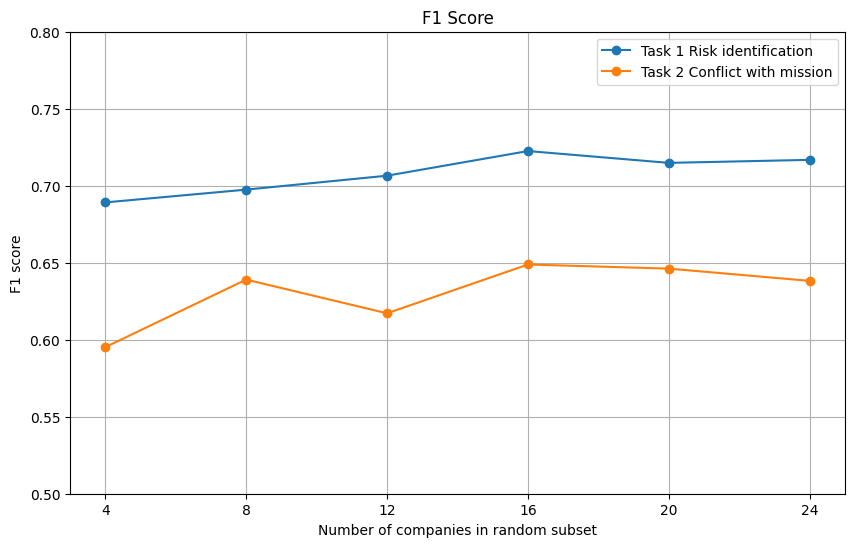

In [ ]:
# Plot the results of F1 score
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, avg_f1_task1_subsets, marker='o', label='Task 1 Risk identification')
plt.plot(subset_sizes, avg_f1_task2_subsets, marker='o', label='Task 2 Conflict with mission')

plt.xlabel('Number of companies in random subset')
plt.ylabel('F1 score')
plt.xticks(subset_sizes)
plt.grid(True)
plt.title('F1 Score')
plt.legend()

plt.ylim(0.5, 0.8)

#plt.savefig('f1_score_randomization_plot.png')

plt.show()

**BERT score**

The Bert score was used to compared the open text responses related to the specific risks and conflict explanations.

In [ ]:
!pip install bert-score

In [ ]:
from bert_score import score

def calculate_bert_score(predicted_texts, ground_truth_texts):
    """
    Calculates BERTScore between a list of predicted texts and a list of ground truth texts.
    Handles non-list inputs by converting them to empty lists.
    """
    # Ensure inputs are lists
    predicted_texts = predicted_texts if isinstance(predicted_texts, list) else []
    ground_truth_texts = ground_truth_texts if isinstance(ground_truth_texts, list) else []

    # Handle empty lists for both predicted and ground truth
    if not predicted_texts and not ground_truth_texts:
        return 1.0, 1.0, 1.0

    # Handle empty predicted list but non-empty ground truth
    if not predicted_texts and ground_truth_texts:
        return 0.0, 0.0, 0.0 # Zero score if predicted is empty but ground truth is not

    # Handle non-empty predicted list but empty ground truth
    if predicted_texts and not ground_truth_texts:
         return 0.0, 0.0, 0.0 # Zero score if ground truth is empty but predicted is not


    # Join lists of texts into single strings for BERTScore calculation
    predicted_joined = " ".join(predicted_texts)
    ground_truth_joined = " ".join(ground_truth_texts)

    #Bert score
    P, R, F1 = score([predicted_joined], [ground_truth_joined], lang="en", verbose=False, model_type="bert-base-uncased")


    return P.item(), R.item(), F1.item()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
# Initialize lists to store BERT scores for each row
precision_bert_task1_list = []
recall_bert_task1_list = []
f1_bert_task1_list = []

precision_bert_task2_list = []
recall_bert_task2_list = []
f1_bert_task2_list = []


# Iterate through each row of the DataFrame
for index, row in tqdm(subset_survey.iterrows(), total=len(subset_survey), desc="Calculating BERT Scores"):
    # For Task 1
    predicted_texts_task1 = row['Task1_majority_risk_texts']
    ground_truth_texts_task1_str = row['Task1_majority_texts_survey']

    # Ensure llm is a list, handling potential NaN or string representations
    if isinstance(predicted_texts_task1, str):
        try:
            # Safely evaluate string representation of list
            predicted_texts_task1 = ast.literal_eval(predicted_texts_task1)
        except:
            predicted_texts_task1 = []
    elif not isinstance(predicted_texts_task1, list):
        predicted_texts_task1 = []

    # Convert survey string representation of list to a list, handling NaN and splitting by punctuation
    ground_truth_texts_task1 = []
    if isinstance(ground_truth_texts_task1_str, str):
        # Split by commas and periods, filter out empty strings
        ground_truth_texts_task1 = [item.strip() for item in re.split(r'[.,]', ground_truth_texts_task1_str) if item.strip()]
    elif not isinstance(ground_truth_texts_task1_str, list) and not pd.isna(ground_truth_texts_task1_str): # Check for non-string/list types and NaNs
        ground_truth_texts_task1 = []
    elif pd.isna(ground_truth_texts_task1_str):
        ground_truth_texts_task1 = []


    p1, r1, f1_1 = calculate_bert_score(predicted_texts_task1, ground_truth_texts_task1)
    precision_bert_task1_list.append(p1)
    recall_bert_task1_list.append(r1)
    f1_bert_task1_list.append(f1_1)

    # For Task 2
    predicted_texts_task2 = row['Task2_majority_risk_texts']
    ground_truth_texts_task2_str = row['Task2_majority_texts_survey']

     # Ensure LLM is a list, handling potential NaN or string representations
    if isinstance(predicted_texts_task2, str):
        try:
            # Safely evaluate string representation of list
            predicted_texts_task2 = ast.literal_eval(predicted_texts_task2)
        except:
            predicted_texts_task2 = []
    elif not isinstance(predicted_texts_task2, list):
        predicted_texts_task2 = []

    # Convert survey string representation of list to a list, splitting by punctuation
    ground_truth_texts_task2 = []
    if isinstance(ground_truth_texts_task2_str, str):
        # Split by commas and periods, filter out empty strings
        ground_truth_texts_task2 = [item.strip() for item in re.split(r'[.,]', ground_truth_texts_task2_str) if item.strip()]
    elif not isinstance(ground_truth_texts_task2_str, list) and not pd.isna(ground_truth_texts_task2_str): # Check for non-string/list types and NaNs
        ground_truth_texts_task2 = []
    elif pd.isna(ground_truth_texts_task2_str):
        ground_truth_texts_task2 = []


    p2, r2, f1_2 = calculate_bert_score(predicted_texts_task2, ground_truth_texts_task2)
    precision_bert_task2_list.append(p2)
    recall_bert_task2_list.append(r2)
    f1_bert_task2_list.append(f1_2)


# Calculate the average BERT scores
avg_precision_bert_task1 = np.mean(precision_bert_task1_list)
avg_recall_bert_task1 = np.mean(recall_bert_task1_list)
avg_f1_bert_task1 = np.mean(f1_bert_task1_list)

avg_precision_bert_task2 = np.mean(precision_bert_task2_list)
avg_recall_bert_task2 = np.mean(recall_bert_task2_list)
avg_f1_bert_task2 = np.mean(f1_bert_task2_list)

print(f"\nTask 1 BERT Scores:")
print(f"  Average Precision: {avg_precision_bert_task1:.4f}")
print(f"  Average Recall: {avg_recall_bert_task1:.4f}")
print(f"  Average F1-score: {avg_f1_bert_task1:.4f}")

print(f"\nTask 2 BERT Scores:")
print(f"  Average Precision: {avg_precision_bert_task2:.4f}")
print(f"  Average Recall: {avg_recall_bert_task2:.4f}")
print(f"  Average F1-score: {avg_f1_bert_task2:.4f}")

Calculating BERT Scores:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Calculating BERT Scores: 100%|██████████| 24/24 [02:48<00:00,  7.04s/it]


Task 1 BERT Scores:
  Average Precision: 0.6087
  Average Recall: 0.6089
  Average F1-score: 0.6085

Task 2 BERT Scores:
  Average Precision: 0.4991
  Average Recall: 0.5107
  Average F1-score: 0.5042


**Randomization**

The same randomization subsets applied on Bert score.

In [ ]:
# Initialize lists to store average BERT F1 scores for each subset size
avg_f1_bert_task1_subsets = []
avg_f1_bert_task2_subsets = []

# Set the random seed for reproducibility (as requested)
random_seed = 15
random.seed(random_seed)
np.random.seed(random_seed)

# Define the subset sizes (as used in previous randomization)
subset_sizes = [4, 8, 12, 16, 20, len(subset_survey)] # Use the full dataset size for the last point

# Iterate through each subset size
for size in subset_sizes:
    # Select a random subset of row indices for this size
    if size < len(subset_survey):
        random_indices = random.sample(range(len(subset_survey)), size)
        subset_df_bert = subset_survey.iloc[random_indices]
    else:
        subset_df_bert = subset_survey # Use the full dataset for the last size

    # Calculate BERT F1 scores for the current subset
    f1_bert_task1_list = []
    f1_bert_task2_list = []

    for index, row in subset_df_bert.iterrows():
        # For Task 1
        predicted_texts_task1 = row['Task1_majority_risk_texts']
        ground_truth_texts_task1_str = row['Task1_majority_texts_survey']

        # Ensure llm is a list, handling potential NaN or string representations
        if isinstance(predicted_texts_task1, str):
            try:
                # Safely evaluate string representation of list
                predicted_texts_task1 = ast.literal_eval(predicted_texts_task1)
            except:
                predicted_texts_task1 = []
        elif not isinstance(predicted_texts_task1, list):
            predicted_texts_task1 = []

        # Convert survey string representation of list to a list, handling NaN and splitting by punctuation
        ground_truth_texts_task1 = []
        if isinstance(ground_truth_texts_task1_str, str):
            # Split by commas and periods, filter out empty strings
            ground_truth_texts_task1 = [item.strip() for item in re.split(r'[.,]', ground_truth_texts_task1_str) if item.strip()]
        elif not isinstance(ground_truth_texts_task1_str, list) and not pd.isna(ground_truth_texts_task1_str): # Check for non-string/list types and NaNs
            ground_truth_texts_task1 = []
        elif pd.isna(ground_truth_texts_task1_str):
            ground_truth_texts_task1 = []


        # Handle cases where both predicted and ground truth are empty lists
        if not predicted_texts_task1 and not ground_truth_texts_task1:
            f1_bert_task1_list.append(1.0) # Perfect score if both are empty
        # Handle cases where predicted is empty but ground truth is not
        elif not predicted_texts_task1 and ground_truth_texts_task1:
            f1_bert_task1_list.append(0.0) # Zero score if predicted is empty but ground truth is not
        # Handle cases where ground truth is empty but predicted is not
        elif predicted_texts_task1 and not ground_truth_texts_task1:
             f1_bert_task1_list.append(0.0) # Zero score if ground truth is empty but predicted is not
        else:
            _, _, f1_1 = calculate_bert_score(predicted_texts_task1, ground_truth_texts_task1)
            f1_bert_task1_list.append(f1_1)


        # For Task 2
        predicted_texts_task2 = row['Task2_majority_risk_texts']
        ground_truth_texts_task2_str = row['Task2_majority_texts_survey']

         # Ensure LLM is a list, handling potential NaN or string representations
        if isinstance(predicted_texts_task2, str):
            try:
                # Safely evaluate string representation of list
                predicted_texts_task2 = ast.literal_eval(predicted_texts_task2)
            except:
                predicted_texts_task2 = []
        elif not isinstance(predicted_texts_task2, list):
            predicted_texts_task2 = []

        # Convert survey string representation of list to a list, splitting by punctuation
        ground_truth_texts_task2 = []
        if isinstance(ground_truth_texts_task2_str, str):
            # Split by commas and periods, filter out empty strings
            ground_truth_texts_task2 = [item.strip() for item in re.split(r'[.,]', ground_truth_texts_task2_str) if item.strip()]
        elif not isinstance(ground_truth_texts_task2_str, list) and not pd.isna(ground_truth_texts_task2_str): # Check for non-string/list types and NaNs
            ground_truth_texts_task2 = []
        elif pd.isna(ground_truth_texts_task2_str):
            ground_truth_texts_task2 = []


        # Handle cases where both predicted and ground truth are empty lists
        if not predicted_texts_task2 and not ground_truth_texts_task2:
            f1_bert_task2_list.append(1.0) # Perfect score if both are empty
        # Handle cases where predicted is empty but ground truth is not
        elif not predicted_texts_task2 and ground_truth_texts_task2:
            f1_bert_task2_list.append(0.0) # Zero score if predicted is empty but ground truth is not
        # Handle cases where ground truth is empty but predicted is not
        elif predicted_texts_task2 and not ground_truth_texts_task2:
             f1_bert_task2_list.append(0.0) # Zero score if ground truth is empty but predicted is not
        else:
            _, _, f1_2 = calculate_bert_score(predicted_texts_task2, ground_truth_texts_task2)
            f1_bert_task2_list.append(f1_2)


    # Calculate average BERT F1 for the current subset size
    avg_f1_bert_task1_subsets.append(np.mean(f1_bert_task1_list) if f1_bert_task1_list else 0.0)
    avg_f1_bert_task2_subsets.append(np.mean(f1_bert_task2_list) if f1_bert_task2_list else 0.0)


# Print the results
print("Average BERT F1 Scores across different subset sizes:")
for i, size in enumerate(subset_sizes):
    print(f"  Subset Size: {size}")
    print(f"    Task 1 Average BERT F1: {avg_f1_bert_task1_subsets[i]:.4f}")
    print(f"    Task 2 Average BERT F1: {avg_f1_bert_task2_subsets[i]:.4f}")

Average BERT F1 Scores across different subset sizes:
  Subset Size: 4
    Task 1 Average BERT F1: 0.6035
    Task 2 Average BERT F1: 0.6046
  Subset Size: 8
    Task 1 Average BERT F1: 0.6041
    Task 2 Average BERT F1: 0.4989
  Subset Size: 12
    Task 1 Average BERT F1: 0.6124
    Task 2 Average BERT F1: 0.4814
  Subset Size: 16
    Task 1 Average BERT F1: 0.6138
    Task 2 Average BERT F1: 0.4680
  Subset Size: 20
    Task 1 Average BERT F1: 0.6078
    Task 2 Average BERT F1: 0.4841
  Subset Size: 24
    Task 1 Average BERT F1: 0.6085
    Task 2 Average BERT F1: 0.5042


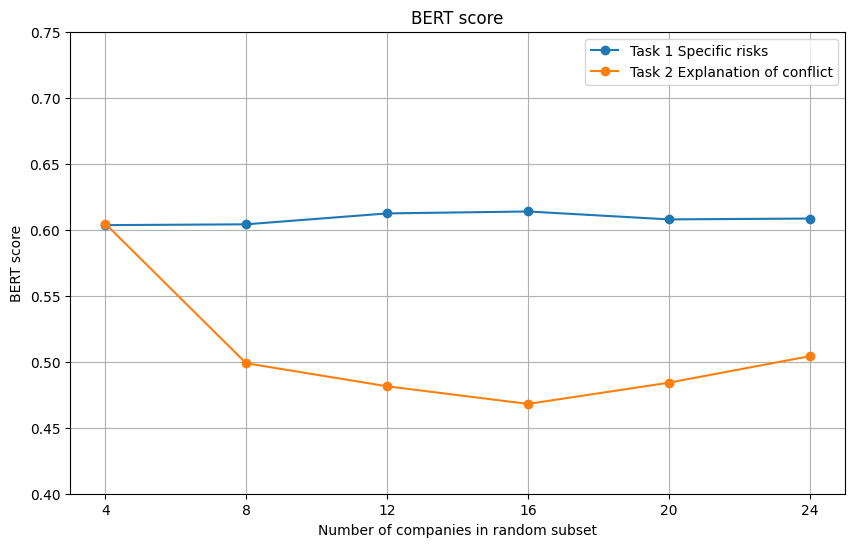

In [ ]:
# Plot the BERT F1 results
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, avg_f1_bert_task1_subsets, marker='o', label='Task 1 Specific risks')
plt.plot(subset_sizes, avg_f1_bert_task2_subsets, marker='o', label='Task 2 Explanation of conflict')

plt.xlabel('Number of companies in random subset')
plt.ylabel('BERT score')
plt.title('BERT score')
plt.xticks(subset_sizes)
plt.grid(True)
plt.legend()
plt.ylim(0.4, 0.75)

plt.savefig('bertscore_randomization_plot.png')
plt.show()

In [ ]:
# Initialize lists to store BERT scores for the random row
precision_bert_task1_list = []
recall_bert_task1_list = []
f1_bert_task1_list = []

precision_bert_task2_list = []
recall_bert_task2_list = []
f1_bert_task2_list = []

import ast
import re


# Get the random row for calculating BERT scores
row = subset_survey.iloc[random_index]

# For Task 1
predicted_texts_task1 = row['Task1_majority_risk_texts']
ground_truth_texts_task1_str = row['Task1_majority_texts_survey']

# Ensure llm is a list, handling potential NaN or string representations
if isinstance(predicted_texts_task1, str):
    try:
        # Safely evaluate string representation of list
        predicted_texts_task1 = ast.literal_eval(predicted_texts_task1)
    except:
        predicted_texts_task1 = []
elif not isinstance(predicted_texts_task1, list):
    predicted_texts_task1 = []

# Convert survey string representation of list to a list, handling NaN and splitting by punctuation
ground_truth_texts_task1 = []
if isinstance(ground_truth_texts_task1_str, str):
    # Split by commas and periods, filter out empty strings
    ground_truth_texts_task1 = [item.strip() for item in re.split(r'[.,]', ground_truth_texts_task1_str) if item.strip()]
elif not isinstance(ground_truth_texts_task1_str, list) and not pd.isna(ground_truth_texts_task1_str): # Check for non-string/list types and NaNs
    ground_truth_texts_task1 = []
elif pd.isna(ground_truth_texts_task1_str):
    ground_truth_texts_task1 = []


p1, r1, f1_1 = calculate_bert_score(predicted_texts_task1, ground_truth_texts_task1)
precision_bert_task1_list.append(p1)
recall_bert_task1_list.append(r1)
f1_bert_task1_list.append(f1_1)

# For Task 2
predicted_texts_task2 = row['Task2_majority_risk_texts']
ground_truth_texts_task2_str = row['Task2_majority_texts_survey']

 # Ensure LLM is a list, handling potential NaN or string representations
if isinstance(predicted_texts_task2, str):
    try:
        # Safely evaluate string representation of list
        predicted_texts_task2 = ast.literal_eval(predicted_texts_task2)
    except:
        predicted_texts_task2 = []
elif not isinstance(predicted_texts_task2, list):
    predicted_texts_task2 = []

# Convert survey string representation of list to a list, splitting by punctuation
ground_truth_texts_task2 = []
if isinstance(ground_truth_texts_task2_str, str):
    # Split by commas and periods, filter out empty strings
    ground_truth_texts_task2 = [item.strip() for item in re.split(r'[.,]', ground_truth_texts_task2_str) if item.strip()]
elif not isinstance(ground_truth_texts_task2_str, list) and not pd.isna(ground_truth_texts_task2_str): # Check for non-string/list types and NaNs
    ground_truth_texts_task2 = []
elif pd.isna(ground_truth_texts_task2_str):
    ground_truth_texts_task2 = []


p2, r2, f1_2 = calculate_bert_score(predicted_texts_task2, ground_truth_texts_task2)
precision_bert_task2_list.append(p2)
recall_bert_task2_list.append(r2)
f1_bert_task2_list.append(f1_2)


# Calculate the average BERT scores for this single row
avg_precision_bert_task1 = np.mean(precision_bert_task1_list)
avg_recall_bert_task1 = np.mean(recall_bert_task1_list)
avg_f1_bert_task1 = np.mean(f1_bert_task1_list)

avg_precision_bert_task2 = np.mean(precision_bert_task2_list)
avg_recall_bert_task2 = np.mean(recall_bert_task2_list)
avg_f1_bert_task2 = np.mean(f1_bert_task2_list)

# Print the results for the random row
print(f"Task 1 BERT Scores for random row (Index: {random_index}, Company ID: {row['ID']}):")
print(f"  Precision: {avg_precision_bert_task1:.4f}")
print(f"  Recall: {avg_recall_bert_task1:.4f}")
print(f"  F1-score: {avg_f1_bert_task1:.4f}")
print(f"  Predicted Texts: {predicted_texts_task1}")
print(f"  Ground Truth Texts: {ground_truth_texts_task1}")


print(f"\nTask 2 BERT Scores for random row (Index: {random_index}, Company ID: {row['ID']}):")
print(f"  Precision: {avg_precision_bert_task2:.4f}")
print(f"  Recall: {avg_recall_bert_task2:.4f}")
print(f"  F1-score: {avg_f1_bert_task2:.4f}")
print(f"  Predicted Texts: {predicted_texts_task2}")
print(f"  Ground Truth Texts: {ground_truth_texts_task2}")

Task 1 BERT Scores for random row (Index: 5, Company ID: 425):
  Precision: 0.6517
  Recall: 0.6381
  F1-score: 0.6449
  Predicted Texts: ['Crop yield predictions fail due to incomplete data', 'inventory management AI misforecasts demand', 'quality control AI incorrectly classifies products as defective.', 'AI for crop yield prediction fails to account for local weather variations, leading to inaccurate forecasts', 'Quality control AI misidentifies defects, allowing substandard products to reach customers.', 'Crop yield predictions prove inaccurate due to incomplete training data, leading to over/understocking', 'Inventory management AI fails to adapt to sudden market changes, causing stockouts or waste', 'Quality control AI misclassifies acceptable products as defective, incurring unnecessary losses.', 'Over-reliance on AI for crop yield prediction leads to loss of traditional farming knowledge', 'AI-driven inventory management prioritizes profit over sustainability', 'AI-enhanced qua

In [ ]:
subset_survey.Task1_majority_texts_survey.loc[0]

"Malicious actors could hack the system to convince the AI to cut the energy power. This could also mean modifying the maintenance of reactors which could be catastrophic., The AI could fail to predict energy surges when they appear in uncommon situations (like a worldcup final when everyone watches TV, or a sudden heathwave when people turn AC on) and thus overload could happen. If the AI has absolute control over grid distribution then that could cause issues as well due to malfunctioning and not assigning the right amount of energy where needed., Malicious actors could take advantage of weaknesses in AI systems that manage grid load balancing or energy trading, potentially disrupting operations or influencing market outcomes. In maintenance systems, they might feed in false data to cause unnecessary repairs or conceal real problems, putting equipment and grid reliability at risk., AI automation may lead to job reductions or changes in workforce demand, while increased energy use fro

## **Ground truth generation**

Now, to use the prompts to generate the ground truth answers for a larger sample of 200 companies (***subset_llm***).

**Llama 3.3 70B**

In [ ]:
from tqdm import tqdm

outputs_llama = []

for _, row in tqdm(subset_llm.iterrows(), total=len(subset_llm)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    usecases = row["Usecases_USC"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "usecases": usecases.strip(),
        "mit_domains": mit_domains,
        "mit_descriptions": mit_descriptions
    }

    try:
        result_llama = chain_llama.invoke(input_dict)
    except Exception as e:
        result_llama = {"error": str(e)}
    outputs_llama.append(result_llama)

100%|██████████| 200/200 [2:05:39<00:00, 37.70s/it]


In [ ]:
outputs_llama

[{'Privacy & Security': 'Connected vehicles leak sensitive driver data; AI-driven supply chain optimization is vulnerable to cyberattacks; Predictive maintenance systems are accessed by unauthorized parties.',
  'Malicious actors': 'Hackers manipulate AI-driven supply chains to disrupt production; Malware is injected into vehicle software updates; Fraudulent AI-generated reports deceive investors and regulators.',
  'Human- Computer Interaction': 'Drivers over-rely on autonomous features, decreasing situational awareness; Insufficient human oversight of AI-driven supply chain optimization leads to errors; Lack of transparency in AI decision-making reduces driver trust.',
  'Socioeconomic & Environmental': 'Job displacement occurs due to automation in manufacturing and maintenance; Increased energy consumption from AI-computed routes and logistics; Unintended environmental consequences from optimized supply chains.',
  'AI system safety, failures, & limitations': 'Predictive maintenance

In [ ]:
subset_llm["Task1_LLaMA"] = outputs_llama

In [ ]:
import json
outputs_llama2 = []

for _, row in tqdm(subset_llm.iterrows(), total=len(subset_llm)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    mission = row["Missions_validated"]
    task_1 = row["Task1_LLaMA"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "mission": mission.strip(),
        "task_1_output": json.dumps(task_1), # Convert dictionary to JSON string
    }

    try:
        result_llama = chain2_llama.invoke(input_dict)
    except Exception as e:
        result_llama = {"error": str(e)}
    outputs_llama2.append(result_llama)

100%|██████████| 200/200 [1:36:33<00:00, 28.97s/it]


In [ ]:
outputs_llama2

[{'Privacy & Security': {'ConflictsMission': 'yes',
   'Explanation': 'Data leaks, cyberattacks undermine trust.'},
  'Malicious actors': {'ConflictsMission': 'yes',
   'Explanation': 'Disruptions, fraud hinder value creation.'},
  'Human- Computer Interaction': {'ConflictsMission': 'yes',
   'Explanation': 'Decreased situational awareness, errors reduce value.'},
  'Socioeconomic & Environmental': {'ConflictsMission': 'yes',
   'Explanation': 'Job displacement, environmental harm contradict mission.'},
  'AI system safety, failures, & limitations': {'ConflictsMission': 'yes',
   'Explanation': 'Safety failures, lack of explainability hinder value.'}},
 {'Discrimination & Toxicity': {'ConflictsMission': 'yes',
   'Explanation': 'Unfairly denies coverage, biased advice undermines responsible corporate citizenship.'},
  'Misinformation': {'ConflictsMission': 'yes',
   'Explanation': 'Inaccurate data, false info compromise long-term growth and earnings.'},
  'Privacy & Security': {'Confli

In [ ]:
subset_llm["Task2_LLaMA"] = outputs_llama2

**Nemotron 70B**

In [ ]:
outputs_nemotron = []

for _, row in tqdm(subset_llm.iterrows(), total=len(subset_llm)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    usecases = row["Usecases_USC"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "usecases": usecases.strip(),
        "mit_domains": mit_domains,
        "mit_descriptions": mit_descriptions
    }

    # LLaMA 3.1 8B
    try:
        result_nemotron = chain_nemotron.invoke(input_dict)
    except Exception as e:
        result_nemotron = {"error": str(e)}
    outputs_nemotron.append(result_nemotron)

100%|██████████| 200/200 [2:29:49<00:00, 44.95s/it]


In [ ]:
outputs_nemotron

[{'Privacy & Security': 'Vehicle data (e.g., location, driving habits) is leaked or exploited for targeted advertising; AI-driven supply chain optimization system vulnerabilities allow cyberattacks on supplier networks; Personalized driving experience collects sensitive biometric data without consent.',
  'Malicious actors': 'Hackers exploit AI predictive maintenance to create fake vehicle malfunction alerts for ransom; Cyberattacks on AI-driven supply chain optimization disrupt global logistics, causing economic losses; Malicious actors manipulate personalized driving experiences to compromise driver safety.',
  'Human- Computer Interaction': 'Overreliance on AI predictive maintenance leads to neglected manual inspection skills among mechanics; Drivers become too dependent on AI-powered personalized driving experiences, diminishing situational awareness; Loss of transparency in AI-driven decisions reduces trust among customers and employees.',
  'Socioeconomic & Environmental': 'Job d

In [ ]:
subset_llm["Task1_Nemotron"] = outputs_nemotron

In [ ]:
outputs_nemotron2 = []

for _, row in tqdm(subset_llm.iterrows(), total=len(subset_llm)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    mission = row["Missions_validated"]
    task_1 = row["Task1_Nemotron"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "mission": mission.strip(),
        "task_1_output": json.dumps(task_1), # Convert dictionary to JSON string
    }

    try:
        result_nemotron = chain2_nemotron.invoke(input_dict)
    except Exception as e:
        result_nemotron = {"error": str(e)}
    outputs_nemotron2.append(result_nemotron)

100%|██████████| 200/200 [2:19:15<00:00, 41.78s/it]


In [ ]:
subset_llm["Task2_Nemotron"] = outputs_nemotron2

**Qwen 2.5 72B**

In [ ]:
outputs_qwen = []

for _, row in tqdm(subset_llm.iterrows(), total=len(subset_llm)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    usecases = row["Usecases_USC"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "usecases": usecases.strip(),
        "mit_domains": mit_domains,
        "mit_descriptions": mit_descriptions
    }
    try:
        result_qwen = chain_qwen.invoke(input_dict)
    except Exception as e:
        result_qwen = {"error": str(e)}
    outputs_qwen.append(result_qwen)

100%|██████████| 200/200 [4:42:19<00:00, 84.70s/it]


In [ ]:
outputs_qwen

[{'Privacy & Security': 'AI-driven supply chain optimization may leak sensitive production data to unauthorized parties; Predictive maintenance systems could be hacked, leading to false positive alerts and vehicle downtime; Personalized driving experience data may be compromised, exposing user preferences and behaviors.',
  'Malicious actors': 'Cyberattacks on AI-driven supply chain systems can disrupt global operations; Malicious manipulation of predictive maintenance algorithms to cause vehicle failures; Fraudulent use of personalized driving data for targeted marketing or identity theft.',
  'Human- Computer Interaction': 'Overreliance on AI for predictive maintenance may lead to under-skilled human technicians; Personalized driving experience AI could reduce driver engagement and awareness; Autonomous supply chain decisions without human oversight can lead to inventory mismanagement.',
  'Socioeconomic & Environmental': 'AI-driven optimization centralizes decision-making, potential

In [ ]:
subset_llm["Task1_Qwen"] = outputs_qwen

In [ ]:
outputs_qwen2 = []

for _, row in tqdm(subset_llm.iterrows(), total=len(subset_llm)):
    company = row["Company"]
    description = row["Description_summary"]
    sector = row["Sector"]
    mission = row["Missions_validated"]
    task_1 = row["Task1_Qwen"]

    input_dict = {
        "company": company.strip(),
        "description": description.strip(),
        "sector": sector.strip(),
        "mission": mission.strip(),
        "task_1_output": json.dumps(task_1), # Convert dictionary to JSON string
    }

    try:
        result_qwen = chain2_qwen.invoke(input_dict)
    except Exception as e:
        result_qwen = {"error": str(e)}
    outputs_qwen2.append(result_qwen)

100%|██████████| 200/200 [4:37:46<00:00, 83.33s/it]


In [ ]:
subset_llm["Task2_Qwen"] = outputs_qwen2

In [ ]:
outputs_qwen2

[{'Privacy & Security': {'ConflictsMission': 'yes',
   'Explanation': 'Data breaches and compromised personalized data conflict with creating value by eroding customer trust and operational integrity.'},
  'Malicious actors': {'ConflictsMission': 'yes',
   'Explanation': 'Cyberattacks and fraudulent use of AI systems disrupt operations and user safety, directly undermining the mission to drive change and create value.'},
  'Human- Computer Interaction': {'ConflictsMission': 'yes',
   'Explanation': 'Overreliance on AI for maintenance and driving can reduce human skills and engagement, conflicting with the goal of aligning strategies and creating sustainable value.'},
  'Socioeconomic & Environmental': {'ConflictsMission': 'yes',
   'Explanation': 'Centralized decision-making and reduced employment quality conflict with the mission to create value by harming local economies and environmental sustainability.'},
  'AI system safety, failures, & limitations': {'ConflictsMission': 'yes',
  

In [ ]:
categories_llama, risks_llama = extract_risks_from_outputs(subset_llm["Task1_dom_LLaMA"])
categories_qwen, risks_qwen = extract_risks_from_outputs(subset_llm["Task1_dom_Qwen"])
categories_nemotron, risks_nemotron = extract_risks_from_outputs(subset_llm["Task1_dom_Nemotron"])

In [ ]:
subset_llm["Task1_dom_LLaMA"] = categories_llama
subset_llm["Task1_text_LLaMA"] = risks_llama

subset_llm["Task1_dom_Qwen"] = categories_qwen
subset_llm["Task1_text_Qwen"] = risks_qwen

subset_llm["Task1_dom_Nemotron"] = categories_nemotron
subset_llm["Task1_text_Nemotron"] = risks_nemotron

**Majority voting**

In [ ]:
from collections import Counter

annotator_category_cols = ["Task1_dom_LLaMA", "Task1_dom_Qwen", "Task1_dom_Nemotron"]

for col in annotator_category_cols:
    # Attempt to convert string representations of lists
    subset_llm[col] = subset_llm[col].apply(
        lambda x: eval(x) if isinstance(x, str) and x.strip().startswith('[') else x
    )
    # Ensure all values in these columns are lists by replacing NaN or other non-list types with an empty list
    subset_llm[col] = subset_llm[col].apply(lambda x: x if isinstance(x, list) else [])


#Majority voting
majority_voted_risks_per_company = []

for index, row in subset_llm.iterrows():
    # Collect all risk categories selected by the three annotators for the current company
    all_categories_for_current_company = []
    for col_name in annotator_category_cols:
        all_categories_for_current_company.extend(row[col_name]) # Extend with the list from each annotator

    # Use Counter to count occurrences of each unique risk category
    category_counts = Counter(all_categories_for_current_company)

    # Identify categories that were selected by at least 2 annotators (majority)
    current_company_majority_risks = [
        category for category, count in category_counts.items() if count >= 2
    ]

    majority_voted_risks_per_company.append(current_company_majority_risks)

# Add the new column to companies_survey DataFrame
subset_llm["Task1_majority_risk_categories"] = majority_voted_risks_per_company


In [ ]:
# List of the columns containing the LLM output dictionaries
llm_task_cols = ["Task1_LLaMA", "Task1_Qwen", "Task1_Nemotron"]
final_majority_texts = []

# Iterate over each row of your DataFrame
for index, row in subset_llm.iterrows():
    # Get the list of majority-voted categories for the current row
    majority_categories = row['Task1_majority_risk_categories']
    collected_row_texts = []

    # For each category that won the majority vote...
    for category in majority_categories:
        # ...check the output of each LLM
        for col in llm_task_cols:
            llm_output_dict = row[col]

            # Check if the output is a dictionary and if it contains the majority category
            if isinstance(llm_output_dict, dict) and category in llm_output_dict:

                # Retrieve the semicolon-separated string of texts
                texts_str = llm_output_dict[category]

                # Split the string into a list, stripping whitespace and removing empty items
                if isinstance(texts_str, str):
                    risk_items = [text.strip() for text in texts_str.split(';') if text.strip()]
                    collected_row_texts.extend(risk_items)

    final_majority_texts.append(collected_row_texts)

# Create the new column with the consolidated list of risk texts
subset_llm["Task1_majority_risk_texts"] = final_majority_texts

# Display the key columns to verify the result
print(subset_llm[["Task1_majority_risk_categories", "Task1_majority_risk_texts"]].head())


                        Task1_majority_risk_categories  \
162  [Privacy & Security, Malicious actors, Human- ...   
421  [Discrimination & Toxicity, Misinformation, Pr...   
435  [Privacy & Security, AI system safety, failure...   
100  [Discrimination & Toxicity, Misinformation, Pr...   
74   [Privacy & Security, Malicious actors, Misinfo...   

                             Task1_majority_risk_texts  
162  [Connected vehicles leak sensitive driver data...  
421  [AI-driven insurance risk assessment unfairly ...  
435  [Exposes customer energy usage patterns to una...  
100  [Biased investment portfolio recommendations a...  
74   [Leaks sensitive shipment data to unauthorized...  


In [ ]:
# Apply the function to each LLM's Task 2 output to create new columns
subset_llm['Task2_dom_LLaMA'] = subset_llm['Task2_LLaMA'].apply(extract_conflicting_risks)
subset_llm['Task2_dom_Qwen'] = subset_llm['Task2_Qwen'].apply(extract_conflicting_risks)
subset_llm['Task2_dom_Nemotron'] = subset_llm['Task2_Nemotron'].apply(extract_conflicting_risks)

In [ ]:
# Define the new columns to perform voting on
annotator_task2_cols = ['Task2_dom_LLaMA', 'Task2_dom_Qwen', 'Task2_dom_Nemotron']

majority_voted_task2_risks = []
for index, row in subset_llm.iterrows():
    # Collect all 'yes' risk categories from the three LLMs for the current row
    all_yes_risks = []
    for col_name in annotator_task2_cols:
        all_yes_risks.extend(row[col_name])

    # Count occurrences of each unique risk category
    category_counts = Counter(all_yes_risks)

    # Identify categories that were marked 'yes' by at least 2 LLMs
    current_company_majority_risks = [
        category for category, count in category_counts.items() if count >= 2
    ]
    majority_voted_task2_risks.append(current_company_majority_risks)

# Add the new column for majority-voted risks to the DataFrame
subset_llm['Task2_majority_risk_categories'] = majority_voted_task2_risks

In [ ]:
# List of the original columns containing the LLM Task 2 dictionaries
llm_task2_cols = ["Task2_LLaMA", "Task2_Qwen", "Task2_Nemotron"]
final_majority_explanations = []

# Iterate over each row of your DataFrame
for index, row in subset_llm.iterrows():
    # Get the list of majority-voted risks for the current row
    majority_risks = row['Task2_majority_risk_categories']
    collected_row_explanations = []

    # For each risk that won the majority vote...
    for risk in majority_risks:
        # ...check the original output of each LLM
        for col in llm_task2_cols:
            llm_output_dict = row[col]

            # Check if the LLM output is a valid dict
            if isinstance(llm_output_dict, dict):
                # Get the details for the specific risk, if it exists
                risk_details = llm_output_dict.get(risk)

                # If the details exist and this LLM voted 'yes'...
                if isinstance(risk_details, dict) and risk_details.get('ConflictsMission', '').lower() == 'yes':
                    # ...get the explanation and add it to our list
                    explanation = risk_details.get('Explanation', 'No explanation provided.')
                    collected_row_explanations.append(explanation)

    final_majority_explanations.append(collected_row_explanations)

# Create the new column with the consolidated list of explanations
subset_llm['Task2_majority_risk_texts'] = final_majority_explanations

# Display the final results to verify
print(subset_llm[['Task2_majority_risk_categories', 'Task2_majority_risk_texts']].head())

                        Task2_majority_risk_categories  \
162  [Privacy & Security, Malicious actors, Human- ...   
421  [Discrimination & Toxicity, Misinformation, Pr...   
435  [Privacy & Security, AI system safety, failure...   
100  [Discrimination & Toxicity, Misinformation, Pr...   
74   [Privacy & Security, Malicious actors, Misinfo...   

    Task2_majority_risk_texts  
162                        []  
421                        []  
435                        []  
100                        []  
74                         []  


**Final output**

I exported the dataset to be used on the 4_RAG_and_evaluation to test the RAG with this dataset.

In [ ]:
subset_llm.to_csv('3_llm_answers.csv')